### Pytania: 
1. W jaki sposób przetworzyć w tym przypadku dane kategorialne? Istnieje MCA, czyli PCA dla kategorialnych 
2. Jakie porównania robić między sobą
3. Czy badać pod kątem zbalansowania?
4. Czy użyć WEKI np. do porównania, czy warto

In [116]:
%matplotlib inline

In [117]:
import pandas as pd
from pathlib import Path 
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import prince
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay


DATA_DIR = Path("../../data")

In [118]:
dataset = pd.read_csv(DATA_DIR / 't-shirts.csv')

In [119]:
dataset.head()

,size,material,color,sleeves,demand
0,S,nylon,white,long,medium
1,XL,polyester,cream,short,high
2,S,silk,blue,short,medium
3,M,cotton,black,short,medium
4,XL,polyester,orange,long,medium


Cechy zostały podzielone na nominalne, czyli bez uporządkowania między nimi, oraz na porządkowe, gdyż możemy ustalić porządek między wartościami. 

In [120]:
nominal = ['material', 'color']
ordinal = ['size', 'sleeves']

features = nominal + ordinal

goal = 'demand'

labels = dataset[goal].drop_duplicates().values.tolist()
labels

['medium', 'high', 'low']

In [121]:
size_labels = ['XS', 'S', 'M' ,'L', 'XL', 'XXL', '3XL']
sleeves_labels = ['short', 'long']

## Eksploracja danych 

Dane są pełne i w całości kategorialne. Większość kategori, oprócz sleeves, jest niezbalansowanych. Będzie to prawdopodobnie miało wpływ na niektóre algorytmy. Jako że są to dane kategorialne, to jedyną ciekawą statystyką jest częstość występowania wartości w danych kategoriach, oraz korelacja (współwystępowanie) z innymi wartościami. Oprócz zmiennej którą chcemy przewidywać nie ma korelacji między atrybutami, co może być istotne w kontekście założeń niektóych algorytmów. 

Kategoria 'demand' jest zmienną, którą chcemy przewidzieć. 

In [122]:
profile = ProfileReport(dataset, title = "T Shirts Report")

In [123]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Rozkład cech ze względu na przypisaną kategorię

<Axes: xlabel='sleeves', ylabel='count'>

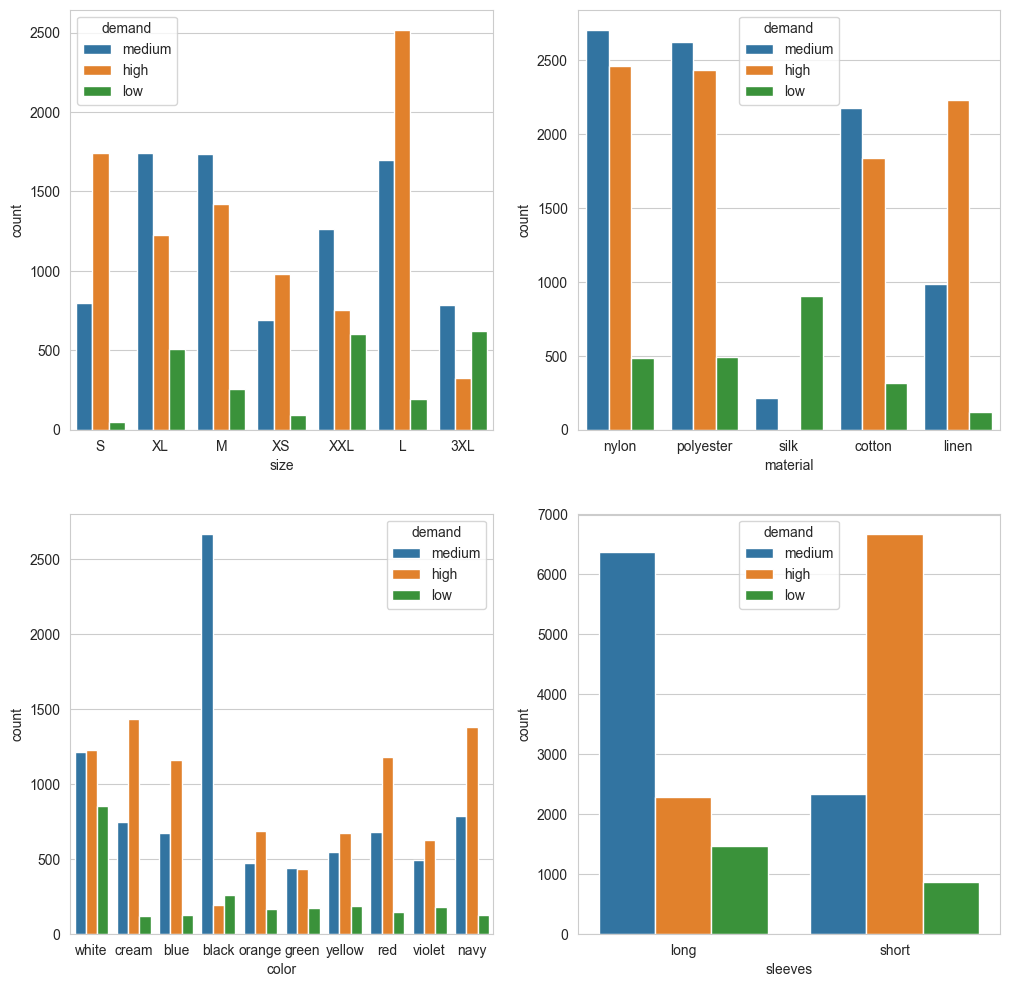

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.countplot(dataset, x='size', hue=dataset[goal], ax=axes[0, 0])
sns.countplot(dataset, x='material', hue=dataset[goal], ax=axes[0, 1])
sns.countplot(dataset, x='color', hue=dataset[goal], ax=axes[1, 0])
sns.countplot(dataset, x='sleeves', hue=dataset[goal], ax=axes[1, 1])

### Podział danych na zbiory

In [125]:
dataset

,size,material,color,sleeves,demand
0,S,nylon,white,long,medium
1,XL,polyester,cream,short,high
2,S,silk,blue,short,medium
3,M,cotton,black,short,medium
4,XL,polyester,orange,long,medium
...,...,...,...,...,...
19995,M,polyester,white,short,medium
19996,M,linen,white,long,high
19997,XXL,cotton,cream,short,high
19998,L,nylon,cream,long,medium


In [126]:
from sklearn.model_selection import train_test_split

# Could add stratification
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, stratify=dataset[goal], random_state=42)

In [127]:
print(f'{train_dataset.size}, {test_dataset.size}')

75000, 25000


Wykorzystany został podział z warstwami ze względu na liczność klas docelowych 

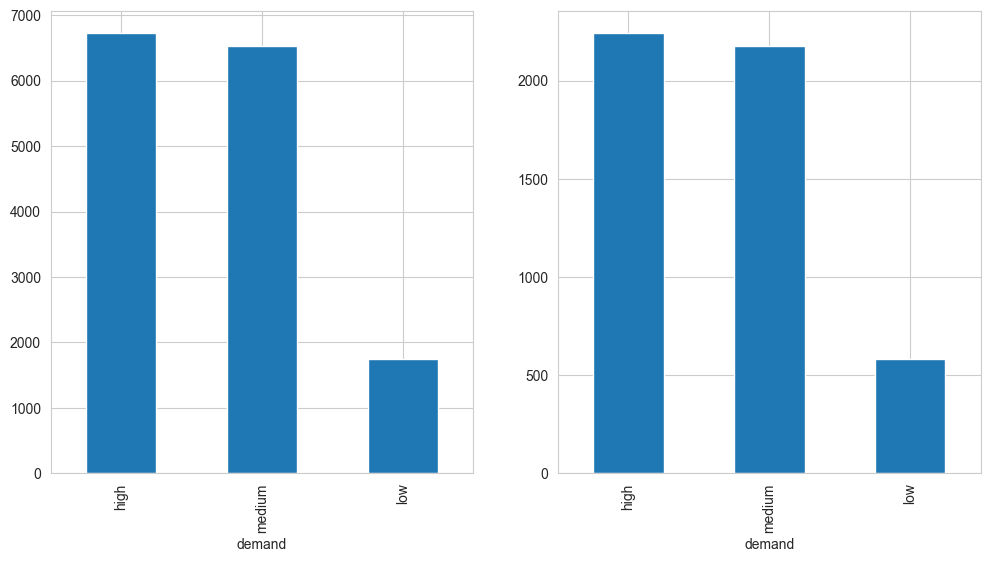

In [128]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_dataset[goal].value_counts().plot(kind='bar')
plt.subplot(1, 2, 2)
test_dataset[goal].value_counts().plot(kind='bar')
plt.show()

In [129]:
features_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
])

In [130]:
preprocessing_pipeline = ColumnTransformer([
    ('nominal_preprocessor', features_pipeline, features)
])

### Naiwny Bayes

In [131]:
from sklearn.naive_bayes import CategoricalNB

complete_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', CategoricalNB())
])

In [132]:
complete_pipeline.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', CategoricalNB())])

In [133]:
score = complete_pipeline.score(test_dataset[features], test_dataset[goal])

In [134]:
score

0.831

In [135]:
cat_nb_grid_search = GridSearchCV(estimator=CategoricalNB(),
                  param_grid={
                      'alpha': [1.0, 0.5],
                      'fit_prior': [True, False],
                      'class_prior': [None, [0.5, 0.1, 0.4]]
                  },
                  scoring='balanced_accuracy', cv=5, verbose=1, refit=True)

cat_nb_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', cat_nb_grid_search)
])

cat_nb_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5, estimator=CategoricalNB(),
                              param_grid={'alpha': [1.0, 0.5],
                                          'class_prior': [None,
                                                          [0.5, 0.1, 0.4]],
                                          'fit_prior': [True, False]},
                              scoring='balanced_accuracy', verbose=1))])

O dziwo klasyfikator działa lepiej, gdy nie są używane prawdopodobieństwa a priori 

In [136]:
pd.DataFrame.from_dict(cat_nb_gs_pipeline.named_steps['estimator'].cv_results_)[['params', 'mean_test_score']]

,params,mean_test_score
0,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.710542
1,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.829481
2,"{'alpha': 1.0, 'class_prior': [0.5, 0.1, 0.4],...",0.705273
3,"{'alpha': 1.0, 'class_prior': [0.5, 0.1, 0.4],...",0.705273
4,"{'alpha': 0.5, 'class_prior': None, 'fit_prior...",0.710542
5,"{'alpha': 0.5, 'class_prior': None, 'fit_prior...",0.829481
6,"{'alpha': 0.5, 'class_prior': [0.5, 0.1, 0.4],...",0.705273
7,"{'alpha': 0.5, 'class_prior': [0.5, 0.1, 0.4],...",0.705273


In [160]:
cat_nb_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', CategoricalNB(class_prior=None, fit_prior=True))
])

cat_nb_pipeline.fit(train_dataset[features], train_dataset[goal])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator', CategoricalNB())])

In [138]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support

def visualize_classification_metrics(y_true, y_pred, name=None):
    metrics = ['precision', 'recall', 'fscore', 'support']
    values = np.array(precision_recall_fscore_support(y_true, y_pred, labels=labels))
    
    values[-1, :] = values[-1, :] / np.sum(values[-1, :])
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pcolormesh(values,
                    cmap='GnBu')
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labels)) + 0.5, labels=labels)
    ax.set_yticks(np.arange(len(metrics)) + 0.5, labels=metrics)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(metrics)):
        for j in range(len(labels)):
            ax.text(j + 0.5, i + 0.5, np.round(values[i, j], 2),
                           ha="center", va="center", color="w")
    
    ax.set_title(f"Classification metrics {' - ' + name if name else ''}")
    fig.tight_layout()
    plt.show()

In [139]:
def visualize_confusion_matrix(y_true, y_pred, name=None):
    values = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(values, display_labels=labels)
    disp.plot()
    
    plt.title(f"Confusion Matrix {' - ' + name if name else ''}")
    fig.tight_layout()
    plt.show()

In [166]:
def class_accuracy(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    return matrix.diagonal() / matrix.sum(axis=1)

In [167]:
confusion_matrix(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), labels=labels)

array([[1772,  112,  293],
       [ 309, 1848,   84],
       [  64,    0,  518]], dtype=int64)

In [168]:
class_accuracy(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]))

array([0.81396417, 0.82463186, 0.89003436])

In [203]:
def results_df(X, y, algorithms, names):
    results = []
    metrics = ['precision', 'recall', 'fscore', 'accuracy']
    
    for alg in algorithms:
        y_pred = alg.predict(X)
        values = np.array(precision_recall_fscore_support(y_pred, y, labels=labels)) 
        values[-1] = class_accuracy(y_pred, y)
        results.append(np.array(values)) # without support
    
    df = pd.DataFrame(np.concatenate(results), columns=labels)
    df['metrics'] = np.tile(np.array(metrics), len(algorithms))
    df['algorithms'] = np.array(names).repeat(4)
    return df

def long_form_results(X, y, algorithms, names):
    melted = pd.melt(res, value_vars=labels, id_vars=['metrics', 'algorithms'])
    melted = melted.rename({'variable': 'label'}, axis=1)
    return melted
    
res = results_df(test_dataset[features], test_dataset[goal], [cat_nb_gs_pipeline, cat_nb_pipeline], ['NB 1', 'NB 2'])   

In [204]:
melted = long_form_results(test_dataset[features], test_dataset[goal], [cat_nb_gs_pipeline, cat_nb_pipeline], ['NB 1', 'NB 2'])

<Axes: xlabel='metrics', ylabel='value'>

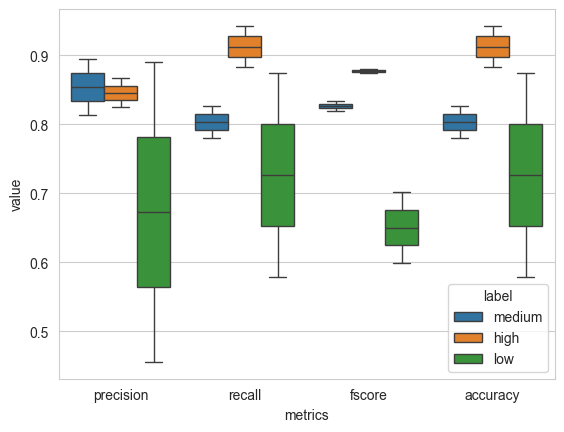

In [207]:
sns.boxplot(melted, y='value', x='metrics', hue='label')

In [162]:
confusion_matrix(test_dataset[goal], cat_nb_pipeline.predict(test_dataset[features]), labels=labels)

array([[1948,  191,   38],
       [ 299, 1942,    0],
       [ 251,   66,  265]], dtype=int64)

<Figure size 500x500 with 0 Axes>

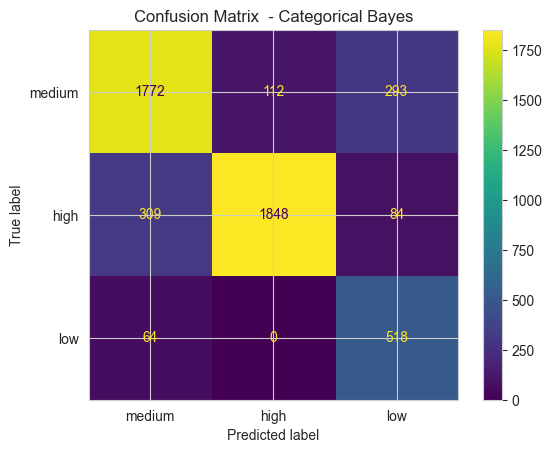

In [142]:
visualize_confusion_matrix(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), 'Categorical Bayes')

<Figure size 500x500 with 0 Axes>

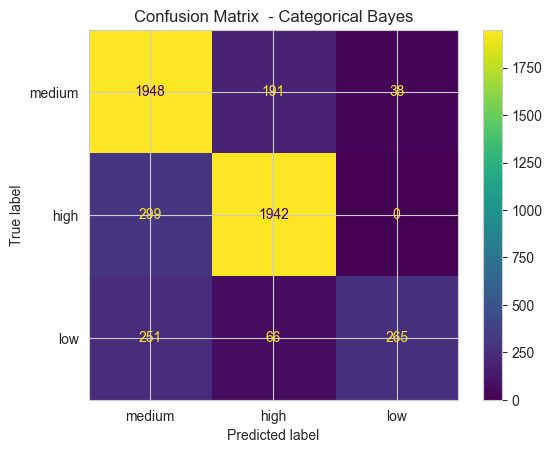

In [163]:
visualize_confusion_matrix(test_dataset[goal], cat_nb_pipeline.predict(test_dataset[features]), 'Categorical Bayes')

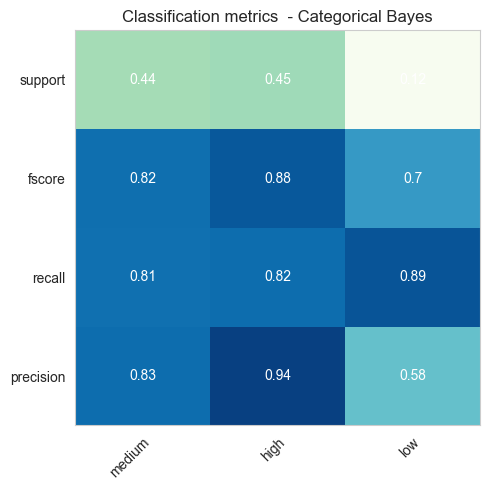

In [143]:
visualize_classification_metrics(test_dataset[goal], cat_nb_gs_pipeline.predict(test_dataset[features]), 'Categorical Bayes')

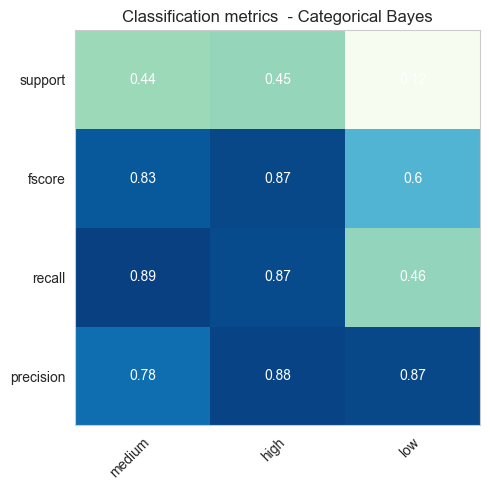

In [164]:
visualize_classification_metrics(test_dataset[goal], cat_nb_pipeline.predict(test_dataset[features]), 'Categorical Bayes')


In [144]:
def visualize_compare_algorithms(X, y, algorithms, names):
    
    results = [precision_recall_fscore_support(y, alg.predict(X), average='micro') for alg in algorithms]
    values = np.array([res[:3] for res in results])
    accuracy = [accuracy_score(y, alg.predict(X)) for alg in algorithms]
    
    metrics = ['precision', 'recall', 'fscore', 'accuracy']
    
    values = np.c_[values, np.array(accuracy)]
    
    fig, ax = plt.subplots()
    ax.pcolormesh(values, cmap='GnBu')
    
    # Show all ticks and label them with the respective list entries
    ax.set_yticks(np.arange(len(names)) + 0.5, labels=names)
    ax.set_xticks(np.arange(len(metrics)) + 0.5, labels=metrics)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(names)):
        for j in range(len(metrics)):
            ax.text(j + 0.5, i + 0.5, np.round(values[i, j], 2),
                           ha="center", va="center", color="w")
    
    ax.set_title(f"Algoritms Comparison")
    fig.tight_layout()
    plt.show()

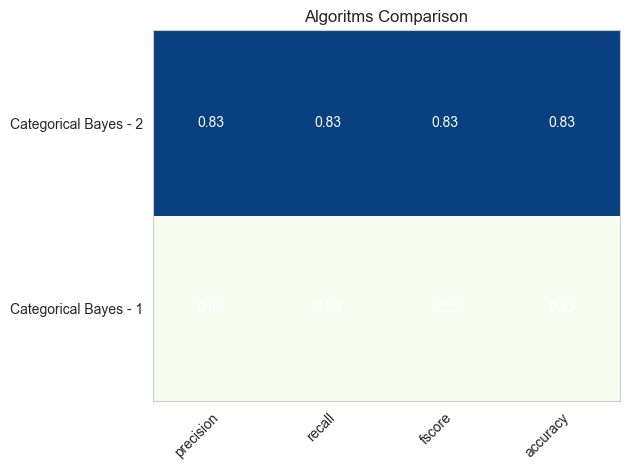

In [161]:
visualize_compare_algorithms(test_dataset[features], test_dataset[goal], [cat_nb_gs_pipeline, cat_nb_pipeline], ['Categorical Bayes - 1', 'Categorical Bayes - 2'])

In [146]:
from sklearn.tree import DecisionTreeClassifier

cat_nb_grid_search = GridSearchCV(estimator=CategoricalNB(),
                  param_grid={
                      'alpha': [1.0, 0.5],
                      'fit_prior': [True, False],
                      'class_prior': [None, [0.5, 0.1, 0.4]]
                  },
                  scoring='balanced_accuracy', cv=5, verbose=1, refit=True)

cat_nb_gs_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('estimator', cat_nb_grid_search)
])

cat_nb_gs_pipeline.fit(train_dataset[features], train_dataset[goal])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['material', 'color', 'size',
                                                   'sleeves'])])),
                ('estimator',
                 GridSearchCV(cv=5, estimator=CategoricalNB(),
                              param_grid={'alpha': [1.0, 0.5],
                                          'class_prior': [None,
                                                          [0.5, 0.1, 0.4]],
                                          'fit_prior': [True, False]},
                              scoring='balanced_accuracy', verbose=1))])

In [147]:
mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(train_dataset)

In [148]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.340,7.72%,7.72%
1,0.300,6.81%,14.53%
2,0.207,4.71%,19.24%


In [149]:
mca.row_coordinates(train_dataset).head()

,0,1,2
3152,-0.432419,-0.117534,-0.156085
2950,0.019294,-0.236738,0.163558
7761,0.198644,-0.467689,0.869136
11332,0.410129,-0.739600,0.284988
1172,0.220498,-0.426101,-0.588123


In [150]:
mca.column_coordinates(train_dataset)

,0,1,2
size_3XL,0.742281,0.863882,-0.309104
size_L,-0.272100,-0.071423,0.020537
size_M,0.195306,-0.177508,-0.511037
size_S,-0.754179,-0.004477,0.067112
size_XL,0.426541,0.082373,0.334139
size_XS,-0.314580,-0.181153,-0.701083
size_XXL,0.097370,-0.191391,0.804262
material_cotton,0.008026,-0.211799,0.366467
material_linen,-0.446045,0.231406,0.795230
material_nylon,-0.077029,-0.145191,0.078126


In [151]:
import altair as alt
alt.data_transformers.enable("vegafusion")

mca.plot(
    train_dataset,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

In [152]:
mca.column_contributions_.head().style.format('{:.0%}')

,0,1,2
size_3XL,3%,4%,1%
size_L,1%,0%,0%
size_M,0%,0%,4%
size_S,4%,0%,0%
size_XL,2%,0%,2%


In [153]:
mca.row_cosine_similarities(train_dataset).head()

,0,1,2
3152,0.041371,0.003056,0.005390
2950,0.000069,0.010383,0.004956
7761,0.011401,0.063197,0.218251
11332,0.051565,0.167691,0.024898
1172,0.011242,0.041982,0.079979


In [154]:
mca.column_cosine_similarities(train_dataset).head()

,0,1,2
size_3XL,0.051799,0.070160,0.008982
size_L,0.020358,0.001403,0.000116
size_M,0.007935,0.006555,0.054327
size_S,0.084041,0.000003,0.000665
size_XL,0.038148,0.001423,0.023410


In [155]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

enc.fit(train_dataset)

OrdinalEncoder()

In [156]:
enc.categories_

[array(['3XL', 'L', 'M', 'S', 'XL', 'XS', 'XXL'], dtype=object),
 array(['cotton', 'linen', 'nylon', 'polyester', 'silk'], dtype=object),
 array(['black', 'blue', 'cream', 'green', 'navy', 'orange', 'red',
        'violet', 'white', 'yellow'], dtype=object),
 array(['long', 'short'], dtype=object),
 array(['high', 'low', 'medium'], dtype=object)]

In [157]:
train_encoded = enc.transform(train_dataset)
test_encoded = enc.transform(test_dataset)

In [158]:
X_train, y_train = train_encoded[:, :len(predictor_columns)], train_encoded[:, len(predictor_columns)]
X_test, y_test = test_encoded[:, :len(predictor_columns)], test_encoded[:, len(predictor_columns)]

NameError: name 'predictor_columns' is not defined

In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred.astype(int)

In [ ]:
reversed = enc.categories_[-1][y_pred.astype(int)]

In [ ]:
reversed

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_pred, y_test)